# Chuẩn bị lib

In [5]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import urllib.request
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline


# Phần 1 : Tải data

Có thể tải dataset từ đây

In [ ]:
!wget 'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt'

In [ ]:
f = open("categories.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
print(classes)

Hoặc định danh từ đây

In [3]:
classes = ['cat', 'tree', 'banana', 'apple']

Tạo thư mục data

In [6]:
def create_data_directory(directory_name='data'):
    """
    Tạo thư mục để lưu trữ dữ liệu nếu nó chưa tồn tại.
    Args:
    - directory_name (str): Tên thư mục.
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

# Sử dụng hàm để tạo thư mục 'data'
create_data_directory()


Tải data

In [8]:
# Part 1: Download Data

def download_data():
    if not os.path.exists('data'):
        os.makedirs('data')

    base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

    for class_name in classes:
        print("Class name : ",class_name)
        class_url = class_name.replace('_', '%20')
        file_path = f'data/{class_name}.npy'
        url = f'{base_url}{class_url}.npy'
        print("URL : ",url)
        urllib.request.urlretrieve(url, file_path)

# Download data
download_data()

Class name :  cat
URL :  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
Class name :  tree
URL :  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy
Class name :  banana
URL :  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
Class name :  apple
URL :  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy


# Phần 2 : Load dữ liệu và chuẩn bị data để train

cat


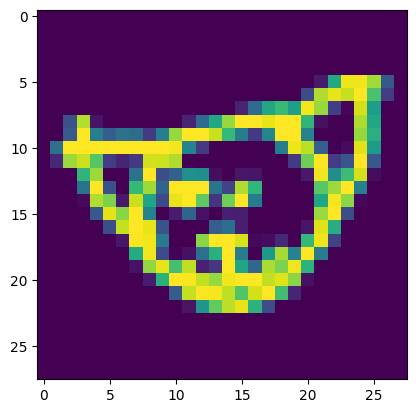

In [9]:
# Part 2: Load and Preprocess Data
def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    x, y, class_names = np.empty([0, 784]), np.empty([0]), []

    for idx, file in enumerate(all_files):
        data = np.load(file)[:max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, _ = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    vfold_size = int(x.shape[0] * vfold_ratio)
    x_test, y_test = x[:vfold_size, :], y[:vfold_size]
    x_train, y_train = x[vfold_size:, :], y[vfold_size:]

    return x_train, y_train, x_test, y_test, class_names

# Load and preprocess data
x_train, y_train, x_test, y_test, class_names = load_data('data')

# Display a random image
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28, 28))
print(class_names[int(y_train[idx])])

# Normalize and reshape data
image_size = 28
x_train = x_train.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0

# Convert class vectors to class matrices
num_classes = len(class_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Phần 3 : Build model

In [10]:
# Part 3: Build Model
model = keras.Sequential([
    layers.Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile Model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['top_k_categorical_accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Phần 4 : Train model

In [11]:
# Part 4: Train Model
model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=256, verbose=2, epochs=6)


Epoch 1/6
45/45 - 10s - loss: 0.5327 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2548 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 223ms/step
Epoch 2/6
45/45 - 10s - loss: 0.2190 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1999 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 220ms/step
Epoch 3/6
45/45 - 13s - loss: 0.1802 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1693 - val_top_k_categorical_accuracy: 1.0000 - 13s/epoch - 283ms/step
Epoch 4/6
45/45 - 12s - loss: 0.1523 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1615 - val_top_k_categorical_accuracy: 1.0000 - 12s/epoch - 256ms/step
Epoch 5/6
45/45 - 10s - loss: 0.1353 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1449 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 222ms/step
Epoch 6/6
45/45 - 8s - loss: 0.1106 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1338 - val_top_k_categorical_accuracy: 1.0000 - 8s/epoch - 174ms/step


# Phần 5 : Đánh giá và dự đoán dữ liệu

In [12]:
# Part 5: Evaluate Model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))


Test accuracy: 100.00%


1/1 [==============================] - 0s 201ms/step
['cat', 'banana', 'tree', 'apple']


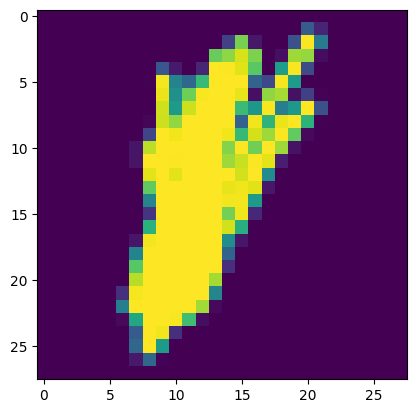

In [13]:
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
top_classes = [class_names[i] for i in ind]
print(top_classes)


# Phần 6 : Lưu model dưới dạng h5 và lưu class name

In [14]:
# Part 6: Save Model and Class Names
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))
model.save('keras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
